<a href="https://colab.research.google.com/github/jppgks/DL-from-Scratch-with-PyTorch/blob/main/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

## Data

In [2]:
texts = [
  "Conditions of workers on coffee plantations are good.",
  "I like coffee a lot.",
  "The coffee tastes good.",
  "Drink coffee.",
  "I like that everyone drinks coffee.",
  "I am interested in learning about the process of making coffee.",
  "He is interested in owning a coffee place.",
  "He likes to drink coffee.",
  "I admire the hard work that goes into producing coffee beans.",

  "Conditions of workers on coffee plantations are bad.",
  "I do not like coffee at all.",
  "The coffee tastes bad",
  "Do not drink coffee.",
  "I hate that everyone drinks coffee.",
  "I am not interested in learning about the process of making coffee.",
  "He is not interested in owning a coffee place.",
  "He does not like to drink coffee.",
  "I do not care about the hard work that goes into producing coffee beans.",
]
sentiment = [
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
]

### Tokenize text

In [3]:
token2idx = dict()

token2idx["[PAD]"] = 0
token2idx["[EOS]"] = 1

for idx, token in enumerate({token.lower() for text in texts for token in text.strip(".").split()}):
  token2idx[token] = len(token2idx)

In [4]:
idx2token = dict((idx, token) for (token, idx) in token2idx.items())

In [5]:
str(token2idx)

"{'[PAD]': 0, '[EOS]': 1, 'likes': 2, 'in': 3, 'making': 4, 'about': 5, 'conditions': 6, 'of': 7, 'not': 8, 'drinks': 9, 'beans': 10, 'drink': 11, 'good': 12, 'does': 13, 'am': 14, 'i': 15, 'goes': 16, 'care': 17, 'owning': 18, 'workers': 19, 'work': 20, 'at': 21, 'producing': 22, 'hard': 23, 'tastes': 24, 'admire': 25, 'are': 26, 'a': 27, 'that': 28, 'into': 29, 'do': 30, 'hate': 31, 'like': 32, 'he': 33, 'everyone': 34, 'coffee': 35, 'process': 36, 'on': 37, 'is': 38, 'place': 39, 'all': 40, 'plantations': 41, 'bad': 42, 'interested': 43, 'lot': 44, 'to': 45, 'learning': 46, 'the': 47}"

In [6]:
idx = token2idx['interested']
idx

43

In [7]:
idx2token[idx]

'interested'

In [8]:
indexes = [
  torch.tensor(
    [token2idx[word] for word in text.lower().strip(".").split()] + [token2idx["[EOS]"]],
    dtype=torch.long
  ).view(-1, 1)
  for text in texts
]
indexes[0].shape

torch.Size([9, 1])

In [9]:
from torch.nn.utils.rnn import pad_sequence

id_tensors_pad = pad_sequence(indexes, batch_first=True)
id_tensors_pad.shape

torch.Size([18, 15, 1])

In [10]:
labels_onehot = F.one_hot(torch.tensor(sentiment), 2).float()
labels_onehot.shape

torch.Size([18, 2])

In [11]:
dataset = torch.utils.data.TensorDataset(id_tensors_pad, labels_onehot)

In [12]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)

In [13]:
X, y = next(iter(dataloader))
X.shape, y.shape

(torch.Size([6, 15, 1]), torch.Size([6, 2]))

In [14]:
print(f"Batch \n {sum(y[:, 0])} neg. samples \n {sum(y[:, 1])} pos. samples")

Batch 
 3.0 neg. samples 
 3.0 pos. samples


## Model

In [15]:
hidden_size = 128

In [16]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, hidden_size, seq_len, pad_idx, eos_idx):
    super(TextClassifier, self).__init__()

    self.pad_idx = pad_idx
    self.eos_idx = eos_idx

    self.embed = nn.Embedding(vocab_size, hidden_size, padding_idx=pad_idx)
    self.rnn = nn.GRU(hidden_size, hidden_size)

    self.attention = nn.Linear(hidden_size, seq_len)
    self.linear = nn.Linear(hidden_size, hidden_size)
    self.dropout = nn.Dropout(.1)
    self.out = nn.Linear(hidden_size, 2)
  
  def forward(self, inputs):
    x = self.embed(inputs).view(inputs.shape[0], inputs.shape[1], -1)
    
    encoder_outputs, _ = self.rnn(x)

    attention_scores = self.attention(encoder_outputs).squeeze(2)

    mask = (inputs == torch.tensor(self.pad_idx)) | (inputs == torch.tensor(self.eos_idx))
    mask = torch.transpose(mask, 1, 2).repeat(1, inputs.shape[1], 1)
    attention_scores = attention_scores.masked_fill(mask, -1e30)

    attention_weights = F.softmax(attention_scores, dim=2)

    context = torch.bmm(attention_weights, encoder_outputs)

    x = self.linear(context)
    x = self.dropout(x)

    out = self.out(x)

    return out, attention_weights

In [17]:
model = TextClassifier(
    vocab_size=len(token2idx), 
    hidden_size=hidden_size, 
    seq_len=id_tensors_pad.shape[1],
    pad_idx=token2idx["[PAD]"],
    eos_idx=token2idx["[EOS]"]
)

In [18]:
out, attn_w = model(X)
out.shape, attn_w.shape

(torch.Size([6, 15, 2]), torch.Size([6, 15, 15]))

## Optimization

In [19]:
loss_fn = nn.BCEWithLogitsLoss()

In [20]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [21]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

In [22]:
model.to(device)

TextClassifier(
  (embed): Embedding(48, 128, padding_idx=0)
  (rnn): GRU(128, 128)
  (attention): Linear(in_features=128, out_features=15, bias=True)
  (linear): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=128, out_features=2, bias=True)
)

In [23]:
epochs = 200
model.train()
for _ in range(epochs):
  for (X, y) in dataloader:
    opt.zero_grad()

    out, attn_weights = model(X.to(device))
    
    loss = loss_fn(out[:, -1, :], y.to(device))

    loss.backward()
    opt.step()

## Inference

In [24]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

def plot_attention(attn_weights, txt_ids, cbar=False):
  ax = sns.heatmap(
      [attn_weights],
      annot=True,
      cmap=sns.color_palette("rocket_r", as_cmap=True),
      xticklabels=list(map(lambda id: idx2token[id], txt_ids)),
      yticklabels=False,
      vmin=0,
      vmax=1,
      square=True,
      cbar_kws={"orientation": "horizontal"},
      cbar=cbar,
  )
  plt.show()

Text: Conditions of workers on coffee plantations are good.
 True label: 1


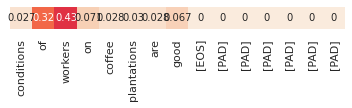

 Prediction correct: True
 tensor([0.0353, 0.9647])


Text: I like coffee a lot.
 True label: 1


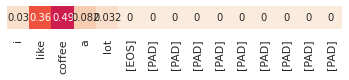

 Prediction correct: True
 tensor([7.3664e-07, 1.0000e+00])


Text: The coffee tastes good.
 True label: 1


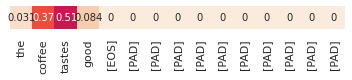

 Prediction correct: True
 tensor([0.0549, 0.9451])


Text: Drink coffee.
 True label: 1


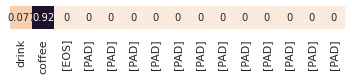

 Prediction correct: True
 tensor([2.2942e-04, 9.9977e-01])


Text: I like that everyone drinks coffee.
 True label: 1


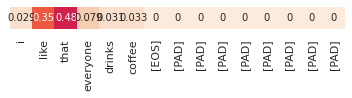

 Prediction correct: True
 tensor([0.0014, 0.9986])


Text: I am interested in learning about the process of making coffee.
 True label: 1


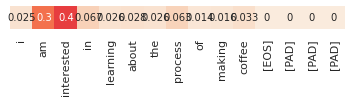

 Prediction correct: True
 tensor([2.2757e-04, 9.9977e-01])


Text: He is interested in owning a coffee place.
 True label: 1


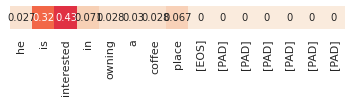

 Prediction correct: True
 tensor([8.1830e-05, 9.9992e-01])


Text: He likes to drink coffee.
 True label: 1


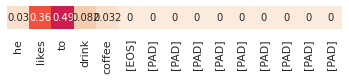

 Prediction correct: True
 tensor([0.0012, 0.9988])


Text: I admire the hard work that goes into producing coffee beans.
 True label: 1


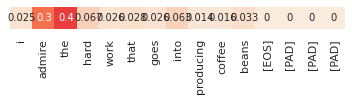

 Prediction correct: True
 tensor([0.0185, 0.9815])


Text: Conditions of workers on coffee plantations are bad.
 True label: 0


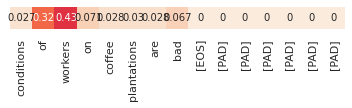

 Prediction correct: True
 tensor([0.8112, 0.1888])


Text: I do not like coffee at all.
 True label: 0


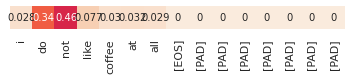

 Prediction correct: True
 tensor([1.0000e+00, 1.5513e-13])


Text: The coffee tastes bad
 True label: 0


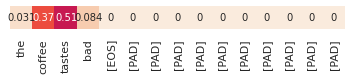

 Prediction correct: True
 tensor([0.9585, 0.0415])


Text: Do not drink coffee.
 True label: 0


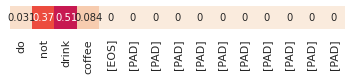

 Prediction correct: True
 tensor([9.9998e-01, 1.9701e-05])


Text: I hate that everyone drinks coffee.
 True label: 0


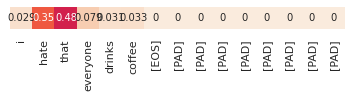

 Prediction correct: True
 tensor([9.9989e-01, 1.0583e-04])


Text: I am not interested in learning about the process of making coffee.
 True label: 0


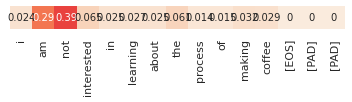

 Prediction correct: True
 tensor([1.0000e+00, 9.3195e-09])


Text: He is not interested in owning a coffee place.
 True label: 0


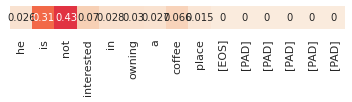

 Prediction correct: True
 tensor([1.0000e+00, 7.5259e-09])


Text: He does not like to drink coffee.
 True label: 0


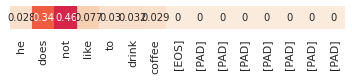

 Prediction correct: True
 tensor([1.0000e+00, 2.2605e-12])


Text: I do not care about the hard work that goes into producing coffee beans.
 True label: 0


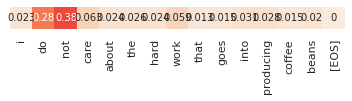

 Prediction correct: True
 tensor([1.0000e+00, 3.6444e-11])




In [26]:
%matplotlib inline
for i in range(round(len(texts))):
  print(f"Text: {texts[i]}\n True label: {sentiment[i]}")
  
  txt_ids = id_tensors_pad[i]
  eos_idx = (txt_ids == torch.tensor(token2idx["[EOS]"])).nonzero()[0, 0].item()

  model.eval()
  out, attn_weights = model(txt_ids.unsqueeze(0).to(device))
  out = out[0, eos_idx]
  attn_weights = attn_weights[0, eos_idx]

  plot_attention(attn_weights[:len(txt_ids)].detach().to("cpu").numpy(), txt_ids.view(-1).numpy(), cbar=False)

  correct = torch.argmax(F.softmax(out.squeeze(), dim=0)).item() == sentiment[i]
  print(f" Prediction correct: {correct}")
  print(f" {F.softmax(out.squeeze().detach(), dim=0)}\n\n")